### Contexto de negócio

Para empresas que vendem assinaturas a retenção de clientes é um indicador chave.

Em muitos mercados os clientes são livres para escolher entre muitos provedores. 

Uma experiência ruim pode ser o suficiente para o cliente mudar para o concorrente.

Prever a perda de clientes é um desafio, mas extremamente importante de ser superado. 

Em setores onde o custo de aquisição de clientes (CAC) é alto, reduzir o churn é uma enorme fonte de receita. 

A rotatividade de clientes (churn) é: 
A porcentagem de clientes que perdidos durante um intervalo de tempo. 

Uma das formas de calcular o churn é dividir o número de clientes perdidos pelo número de clientes ativos. 

Exemplo, se você tem 1.000 clientes e perdeu 50 no mês passado, sua taxa de churn mensal é de 5%.

O objetivo principal do modelo de churn é prever quais são os clientes com o maior risco de serem perdidos. Essa previsão fomentará ações provativas para evitar a perda desses clientes.

### Importando a base de dados

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/home/tomate/Documents/PORTFOLIO/Predict Customer Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Preparando os dados

In [3]:
df.TotalCharges = df.TotalCharges.replace(' ', np.nan)
df.TotalCharges = df.TotalCharges.astype('float64')

In [4]:
import plotly.express as px

fig = px.scatter(x=df['tenure'], y=df['TotalCharges'], 
                 color = df['Churn'], template = 'presentation', 
                 opacity = 0.5, facet_col = df['Contract'], 
                 title = 'Customer Churn by Tenure, Charges, and Contract Type',
                 labels = {'x' : 'Customer Tenure', 'y' : 'Total Charges $'})

fig.show()

In [5]:
from pycaret.classification import *

s = setup(df, target = 'Churn', ignore_features = ['customerID'])

,Description,Value
0,session_id,8180
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


### Escolhendo modelos

In [6]:
melhor_modelo = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7943,0.8429,0.5023,0.6407,0.5626,0.4308,0.4366,0.2820
ada,Ada Boost Classifier,0.7990,0.8422,0.5292,0.6451,0.5811,0.4507,0.4546,0.1140
lr,Logistic Regression,0.8024,0.8407,0.5369,0.6524,0.5888,0.4604,0.4644,0.4180
catboost,CatBoost Classifier,0.7961,0.8365,0.5008,0.6479,0.5641,0.4340,0.4406,2.1210
lda,Linear Discriminant Analysis,0.7959,0.8353,0.5469,0.6303,0.5850,0.4508,0.4532,0.0240
nb,Naive Bayes,0.7428,0.8268,0.7615,0.5089,0.6099,0.4293,0.4489,0.0170
xgboost,Extreme Gradient Boosting,0.7840,0.8159,0.5115,0.6079,0.5548,0.4138,0.4169,26.0500
rf,Random Forest Classifier,0.7888,0.8153,0.4669,0.6370,0.5383,0.4056,0.4142,0.2850
et,Extra Trees Classifier,0.7696,0.7832,0.4638,0.5790,0.5145,0.3660,0.3702,0.2530
lightgbm,Light Gradient Boosting Machine,0.7120,0.7474,0.4585,0.5662,0.5062,0.3846,0.3885,27.9970


In [7]:
print(melhor_modelo)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8180, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Ajustando o melhor modelo

In [8]:
melhor_modelo_ajustado = tune_model(melhor_modelo)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8134,0.8399,0.5538,0.6792,0.6102,0.4892,0.4936
1,0.8032,0.8450,0.5692,0.6435,0.6041,0.4738,0.4754
2,0.7890,0.8173,0.5000,0.6250,0.5556,0.4195,0.4240
3,0.8012,0.8364,0.4923,0.6667,0.5664,0.4412,0.4497
4,0.8012,0.8285,0.4846,0.6702,0.5625,0.4382,0.4478
5,0.7789,0.8117,0.4769,0.6019,0.5322,0.3900,0.3945
6,0.7992,0.8362,0.5462,0.6396,0.5892,0.4574,0.4599
7,0.7769,0.8132,0.4769,0.5962,0.5299,0.3860,0.3901
8,0.8053,0.8301,0.5308,0.6635,0.5897,0.4641,0.4691


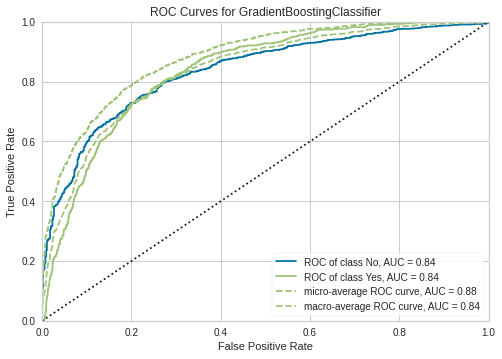

In [9]:
plot_model(melhor_modelo_ajustado, plot='auc')

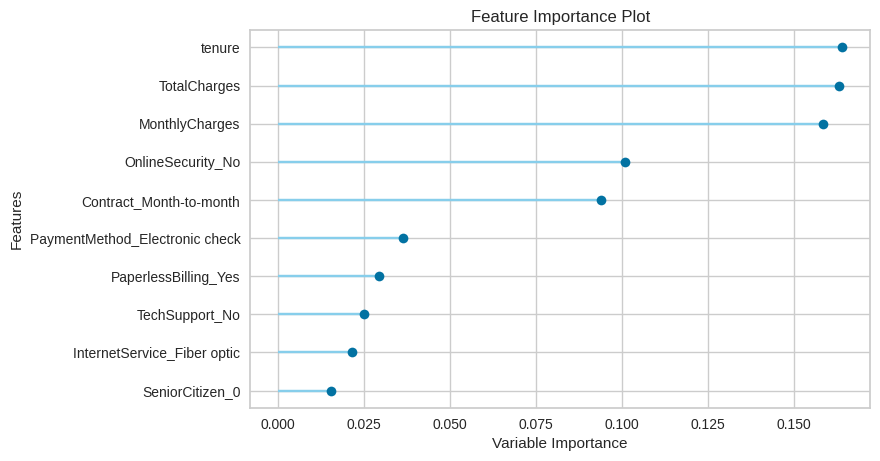

In [10]:
plot_model(melhor_modelo_ajustado, plot = 'feature')


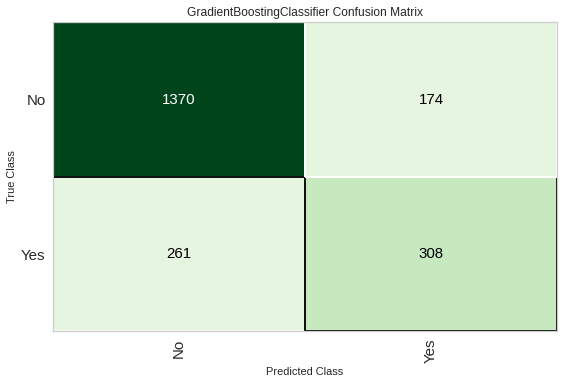

In [11]:
plot_model(melhor_modelo_ajustado, plot = 'confusion_matrix')


A melhor AUC não se traduz necessariamente no melhor modelo para o negócio.

Em um modelo de churn, muitas vezes a recompensa dos verdadeiros positivos é muito diferente do custo dos falsos positivos. 

Supondo que:

Será oferecido um voucher de $1.000 a todos os clientes identificados como churn (Verdadeiro Positivo + Falso Positivo);

Se conseguirmos interromper o churn, ganharemos US$ 5.000 em vida útil do cliente.

| Descrição | Clientes | $ Valor | Total
   |---|---|---|---|
   | Verdadeiro Positivo | 308 | $ 5.000 | $ 1.540.000 |
   | Verdadeiro Positivo + Falso Positivo | 482 | -$ 1.000 | -$ 482.000 |
   ||||$ 1.058.000|

Usando essas suposições e a confusion matrix, podemos calcular o impacto financeiro do modelo:

É um bom modelo, mas o problema é que não é um modelo inteligente.
 
Como podemos treinar e selecionar um modelo que maximize a geração de receita? 

Para isso, otimizaremos modelos usando uma métrica de negócios em vez de uma convencional, como AUC ou Precisão.

### Uma métrica de personalizada

In [12]:
# create a custom function
def calculadora_lucro(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (5000-1000), 0)
    fp = np.where((y_pred==1) & (y==0), -1000, 0)
    return np.sum([tp, fp])

# add metric to PyCaret
add_metric('profit', 'Profit', calculadora_lucro)

Name                                                         Profit
Display Name                                                 Profit
Score Function       <function calculadora_lucro at 0x7f8446677d30>
Scorer                               make_scorer(calculadora_lucro)
Target                                                         pred
Args                                                             {}
Greater is Better                                              True
Multiclass                                                     True
Custom                                                         True
Name: profit, dtype: object

In [13]:
melhor_modelo = compare_models(sort='Profit')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
nb,Naive Bayes,0.7428,0.8268,0.7615,0.5089,0.6099,0.4293,0.4489,300200.0000,0.0100
lda,Linear Discriminant Analysis,0.7959,0.8353,0.5469,0.6303,0.5850,0.4508,0.4532,242700.0000,0.0180
lr,Logistic Regression,0.8024,0.8407,0.5369,0.6524,0.5888,0.4604,0.4644,242000.0000,0.0670
ada,Ada Boost Classifier,0.7990,0.8422,0.5292,0.6451,0.5811,0.4507,0.4546,237300.0000,0.1080
ridge,Ridge Classifier,0.7970,0.0000,0.5000,0.6497,0.5645,0.4352,0.4419,224900.0000,0.0100
catboost,CatBoost Classifier,0.7961,0.8365,0.5008,0.6479,0.5641,0.4340,0.4406,224800.0000,2.0530
gbc,Gradient Boosting Classifier,0.7943,0.8429,0.5023,0.6407,0.5626,0.4308,0.4366,224500.0000,0.2940
xgboost,Extreme Gradient Boosting,0.7840,0.8159,0.5115,0.6079,0.5548,0.4138,0.4169,223000.0000,23.2590
rf,Random Forest Classifier,0.7888,0.8153,0.4669,0.6370,0.5383,0.4056,0.4142,208000.0000,0.2430
lightgbm,Light Gradient Boosting Machine,0.7120,0.7474,0.4585,0.5662,0.5062,0.3846,0.3885,203100.0000,19.9680


Com a métrica Profit surpreendentemente Naive Bayes, que é um modelo muito ruim em termos de AUC, é o melhor modelo quando se trata de lucro.

O número total de clientes ainda é o mesmo (2.113 clientes no conjunto de teste), o que mudou agora é como o modelo está cometendo erros sobre falsos positivos e falsos negativos.

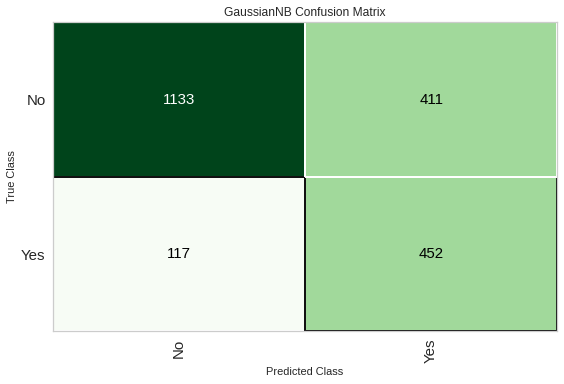

In [14]:
plot_model(melhor_modelo, plot = 'confusion_matrix')


Fazendo as mesmas suposições de valores para o problema de negócio:

| Descrição | Clientes | $ Valor | Total
   |---|---|---|---|
   | Verdadeiro Positivo | 452 | $ 5.000 | $ 2.260.00 |
   | Verdadeiro Positivo + Falso Positivo | 863 | -$ 1.000 | -$ 863.000 |
   ||||$ 1.397.000 |

### Conclusão

Acabamos de aumentar o lucro em ~$400.000 com um modelo que faz 2% menos em AUC do que o melhor modelo. 

Como isso acontece? AUC ou qualquer outra métrica convencional  (Precisão, Recall, Precisão, F1, Kappa, etc.) não é uma métrica com iteligênica de negócio. 

Por isso não considera a relação risco retorno para a empresa. 

Adicionar uma métrica personalizada e usá-la para seleção e otimização de modelo é uma ótima ideia.